In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import yfinance as yf

In [10]:
# Download and prepare data
df = yf.download('AAPL', start='2020-01-01', end='2025-09-01', interval='1d', auto_adjust=True)

# We only need the 'Close' price for this example
data = df[['Close']].copy()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [11]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Use last 60 days to predict next day
X, y = create_sequences(scaled_data, SEQ_LENGTH)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1363, 60, 1), y shape: (1363, 1)


In [12]:
# Build LSTM Model
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),  # Explicit Input layer
    LSTM(50, return_sequences=False),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the Model
history = model.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.0281
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0015
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 9.5055e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 8.8949e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 8.9543e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 8.7286e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 8.5611e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 8.3363e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 8.4930e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 8.0382e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 7.9442e-04
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 7.6144e-04
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 7.6212e-04
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 7.7689e-04
Epoch 

In [14]:
# Make Predictions

# Predict next day price
last_seq = scaled_data[-SEQ_LENGTH:]
last_seq = last_seq.reshape((1, SEQ_LENGTH, 1))

pred_scaled = model.predict(last_seq)
pred_price = scaler.inverse_transform(pred_scaled)

print(f"Predicted next closing price: ${pred_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted next closing price: $228.78


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


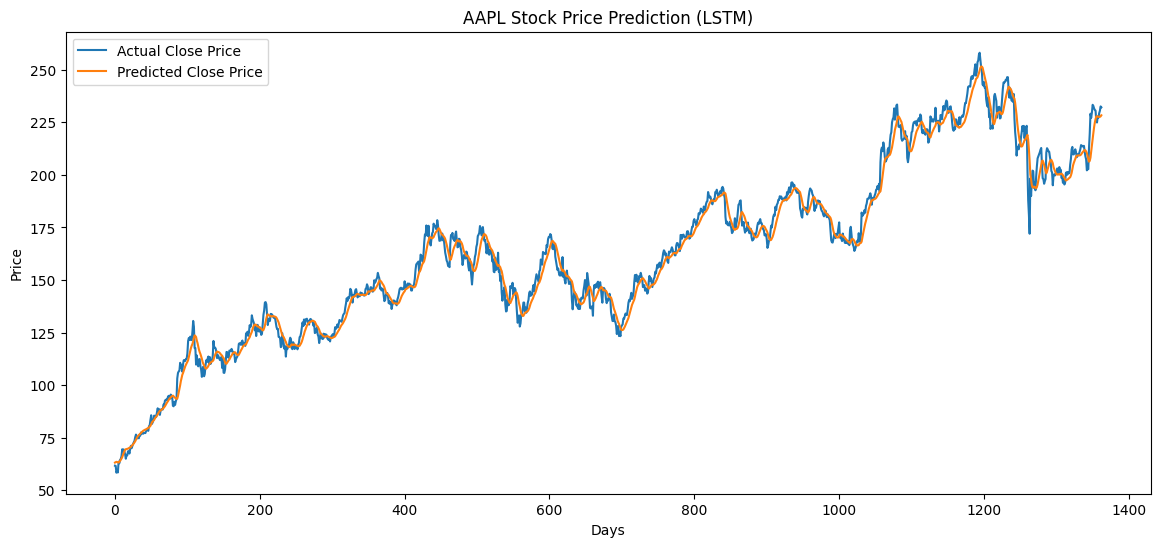

In [15]:
# Visualize Training Predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)
true_prices = scaler.inverse_transform(y)

plt.figure(figsize=(14, 6))
plt.plot(true_prices, label="Actual Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.title("AAPL Stock Price Prediction (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()